In [1]:
nombre = 'balanced2'

In [ ]:
free_memory()

# Preload

In [2]:
# !pip install pyvolutionary==2.4.2
# !pip install pycaret
# !pip install pycaret[full]
# !pip install scikit_learn==1.4
# !pip install nlpaug==1.1.11

In [3]:
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from numpy.linalg import svd
import requests
import json


sscaler = StandardScaler()
rscaler = RobustScaler()
mmscaler = MinMaxScaler()
mascaler = MaxAbsScaler()

le = LabelEncoder()

def lencoder(df, col, lenc=False, train=True):
    if train:
        label = le.fit_transform(df[col])
        df[col] = pd.to_numeric(label)
        return df,le
    elif lenc != False:
        label = lenc.transform(df[col])
        df[col] = pd.to_numeric(label)
        return df
    else:
        print('Nothing done')
        return df



In [4]:
def run_kfold_model (model, X,y,K=10,graph=True):
    regr = LinearRegression()
    kf = KFold(n_splits=5)
    s=1
    for train_index, test_index in kf.split(X):
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        print('Slice '+str(s)+' score: '+str(regr.score(X_test, y_test)))
        y_pred = model.predict(X_test)
        scores(y_test, y_pred)
        if graph:
            plt.scatter(y_test, y_pred, color = 'red', marker = 'o', s = 35, alpha = 0.5, label = 'Test data')
            plt.show()
        s+=1
    return(regr)

In [5]:
# def scores (model, X_train, X_test, y_test, y_pred, graph=True):
#     MAE=metrics.mean_absolute_error(y_test, y_pred)
#     MSE=metrics.mean_squared_error(y_test, y_pred)
#     RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
#     CV_RMSE= (RMSE/np.average(y_test))*100
#     R2=metrics.r2_score(y_test, y_pred)
#     ACC=metrics.accuracy_score
#     REC=metrics.recall_score
#     PREC=metrics.precision_score

#     print('MAE:'+str(MAE))
#     print('MSE:'+str(MSE))
#     print('RMSE:'+str(RMSE))
#     print('CV(RMSE): '+str(CV_RMSE))
#     print('R2:'+str(R2))
#     print('Accuracy:'+str(ACC))
#     print('Recall:'+str(REC))
#     print('Precision:'+str(PREC))

#     # print('Training score: '+str(model.score(X_train, y_train))) #(Accuracy or R2)
#     # print('Test score: '+str(model.score(X_test, y_train)))
#     if graph == True:
#         plt.scatter(y_train, y_pred, color = 'red', marker = 'o', s = 35, alpha = 0.5, label = 'Test data')
#         plt.show()

In [6]:
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef

def scores(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Recall
    recall = recall_score(y_test, y_pred,average='weighted')
    print("Recall:", recall)

    # Precision
    precision = precision_score(y_test, y_pred,average='weighted')
    print("Precision:", precision)

    # F1 Score
    f1 = f1_score(y_test, y_pred,average='weighted')
    print("F1 Score:", f1)

    # Cohen's Kappa
    kappa = cohen_kappa_score(y_test, y_pred)
    print("Cohen's Kappa:", kappa)

    # Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_test, y_pred)
    print("MCC:", mcc)


In [7]:
import dask.dataframe as dd

In [8]:
from ast import literal_eval
def clean(x):
    return literal_eval(x)

In [9]:
pd.set_option("mode.copy_on_write", True)
pd.options.mode.copy_on_write = True

In [10]:
import math

def dummies(df, col):
    tDummy = pd.get_dummies(df[col]).add_prefix(col+'_')
    df = pd.concat([df,tDummy],axis=1).reindex(df.index)
    return(df)

def just_dummies(df, col):
    tDummy = pd.get_dummies(df[col]).add_prefix(col+'_')
    return(tDummy)

def just_dummies_steps(df, col, ix):
    num_chunks = math.ceil(len(df) / ix)  # Calculate number of chunks
    all_dummies = []  # Store results from each chunk

    for i in range(num_chunks):
        start = i * ix  # Starting index for the current chunk
        end = (i + 1) * ix  # Ending index for the current chunk

        chunk = df.loc[start:end-1] # Select chunk of data for the dummies
        chunk_dummies = just_dummies(chunk, col)  # Apply just_dummies to chunk
        all_dummies.append(chunk_dummies)  # Append the output to the list

    # Concatenate all dummy DataFrames horizontally
    final_dummies = pd.concat(all_dummies, axis=1)
    return final_dummies

In [11]:
def columns_with_nan(df):
    # Obtener una lista de los nombres de las columnas
    columns = df.columns.to_list()

    # Filtrar las columnas que tienen valores NaN
    columns_with_nan = [col for col in columns if df[col].isna().any()]

    return columns_with_nan

def rows_with_nan(df, column_name):
    # Filtrar las filas donde la columna especificada tiene valores NaN
    rows_with_nan = df[df[column_name].isna()]
    return rows_with_nan

In [12]:
import gc

def free_memory():
    # Variables used in initial data loading and NLP
    variables_to_delete = [
        'data', 'exploded', 'exploded_filtered', 'checkit', 'checkot', 'checket',
        'wordlst', 'over1', 'tfidf_Psummary', 'tfidf_Pdescription', 'mwe_tokenizer',
        'tokenizer', 'stop_words', 'lemmatizer', 'text', 'tokenised',
        'retokenised', 'normalised', 'unmarked', 'filtered', 'lemmatised'
    ]

    # Variables used for model training and evaluation
    variables_to_delete.extend([
        'dataHM', 'datarf',  'dataset', 'X', 'Y', 'X_train', 'X_test',
        'y_train', 'y_test', 'dtrain', 'dtest', 'output', 'y_pred',
        'clf1', 'best_model', 'tuned_model', 'model', 'rf_model',
        'params', 'accuracy', 'grid_search',  'evolution', 'result',
        'ros', 'X_ros', 'y_ros', 'rus', 'X_rus', 'y_rus', 'smote', 'X_smote',
        'y_smote', 'adasyn', 'X_adasyn', 'y_adasyn', 'smoteenn', 'X_smoteenn',
        'y_smoteenn', 'class_names','correlations','selected_features'
    ])


    # Delete the variables
    for var in variables_to_delete:
        if var in globals():  # Check if variable exists
            del globals()[var]

    # Run garbage collection
    gc.collect()

    print("Memory freed!")

# Checkpoint 1 Get data

In [ ]:
# data = pd.read_excel('mozilla-bugs-all.xlsx')
# data.describe

In [ ]:
def json_data(URL,params):
    headers = {"Accept" : "application/json"}
    resp = requests.get(URL, params= params, headers= headers)
    df = pd.DataFrame()
    if resp.status_code != 200:
        print('error: ' + str(resp.status_code))
    else:
        print('Success')
        bugs = resp.text
        data = json.loads(bugs)
        df = pd.json_normalize(data['bugs'])
    return(df)

params ={
    "include_fields" : ["id"
                        ,"summary"
                        ,"status"
                        ,"description"
                        ,"type"
                        ,"classification"
                        ,"product"
                        ,"component"
                        ,"priority"
                        ,"assigned_to"
                        ,"resolution"
                        ,"creation_time"
                        ,"last_change_time"
                        ,"severity"
                        ,"version"
                        ]
    ,"product" : "Core"
    ,"severity" : ["S1"]
    # ,"status" : ["VERIFIED","RESOLVED","CLOSED","UNCONFIRMED","NEW"]
    ,"limit" : 1000
    ,"order": "opendate DESC"
}
URL = "https://bugzilla.mozilla.org/rest/bug"


In [ ]:
params["status"] = "RESOLVED"
params.pop("status", None)

test_df = json_data(URL,params)
print(test_df.columns.to_list())
test_df.tail()

Success
['priority', 'version', 'last_change_time', 'assigned_to', 'description', 'severity', 'classification', 'summary', 'status', 'product', 'creation_time', 'id', 'component', 'resolution', 'type', 'assigned_to_detail.email', 'assigned_to_detail.real_name', 'assigned_to_detail.id', 'assigned_to_detail.nick', 'assigned_to_detail.name']


,priority,version,last_change_time,assigned_to,description,severity,classification,summary,status,product,creation_time,id,component,resolution,type,assigned_to_detail.email,assigned_to_detail.real_name,assigned_to_detail.id,assigned_to_detail.nick,assigned_to_detail.name
190,P1,unspecified,2020-05-18T19:14:56Z,docfaraday@gmail.com,This bug is for crash report bp-357d3ef4-a78d-...,S1,Components,Crash in [@ mozilla::MozPromise<T>::Private::R...,VERIFIED,Core,2020-05-08T22:47:46Z,1636615,Audio/Video: Playback,FIXED,defect,docfaraday@gmail.com,Byron Campen [:bwc],478411,bwc,docfaraday@gmail.com
191,P2,78 Branch,2020-07-15T02:09:47Z,nobody@mozilla.org,User Agent: Mozilla/5.0 (Macintosh; Intel Mac ...,S1,Components,meet.google.com takes 10 seconds until others ...,RESOLVED,Core,2020-05-08T22:42:53Z,1636614,WebRTC: Audio/Video,FIXED,defect,nobody@mozilla.org,Nobody; OK to take it and work on it,1,nobody,nobody@mozilla.org
192,P1,76 Branch,2020-06-29T21:02:04Z,nobody@mozilla.org,User Agent: Mozilla/5.0 (Windows NT 10.0; Win6...,S1,Components,nsIPKCS11ModuleDB.addModule failure in 76+ (Es...,RESOLVED,Core,2020-05-07T12:32:32Z,1636100,Security: PSM,DUPLICATE,defect,nobody@mozilla.org,Nobody; OK to take it and work on it,1,nobody,nobody@mozilla.org
193,--,75 Branch,2020-06-17T07:11:27Z,zibi@braniecki.net,User Agent: Mozilla/5.0 (Macintosh; Intel Mac ...,S1,Components,Context menus are blank on macOS,RESOLVED,Core,2020-04-11T17:56:55Z,1629291,Internationalization,FIXED,defect,zibi@braniecki.net,Zibi Braniecki [:zbraniecki][:gandalf],41270,zbraniecki,zibi@braniecki.net
194,P1,unspecified,2022-04-18T19:22:12Z,acreskey@mozilla.com,While looking at profiles generated as part of...,S1,Components,Determine if we are indeed spending up to 3x a...,RESOLVED,Core,2019-09-23T18:20:19Z,1583298,Performance,WORKSFORME,task,acreskey@mozilla.com,Andrew Creskey [:acreskey],624474,acreskey,acreskey@mozilla.com


In [ ]:
# for i in test_df.columns.to_list():
#     print("Column "+i+" unique values:")
#     # print(test_df[i].unique())
#     print(test_df[i].value_counts())

#     print()


In [ ]:
# test_df.groupby(['resolution']).sum().plot(kind='pie', y='id', autopct='%1.0f%%', labeldistance=None)
# from datetime import datetime
import csv

# print(test_df['creation_time'].min())
# datetime.now() - pd.to_datetime(pd.to_datetime(test_df['creation_time'][test_df['resolution']=='FIXED']).values.astype(np.int64).mean())
# plt.pie(x=test_df['resolution'].unique(), labels=test_df['resolution'].value_counts())
# plt.show()

# plt.title('Category Distribution')
# plt.ylabel('')  # Hide the y-label
# plt.show()

# test_df.to_csv("dataset_20241023.csv")
test_df.to_csv("dataset_"+nombre+".csv", escapechar='\\', quoting=csv.QUOTE_NONNUMERIC)


# test_df.date = pd.to_datetime(test_df.date).values.astype(np.int64)

# test_df = pd.DataFrame(pd.to_datetime(test_df.groupby('column').mean().date))

# Checkpoint 2 NLP

In [13]:
data = pd.read_csv('dataset_'+nombre+'.csv', index_col = 'id')
data.describe

<bound method NDFrame.describe of              index  Unnamed: 0               assigned_to  \
id                                                         
1809860.0        0         999      apehrson@mozilla.com   
1809985.0        1         998          alwu@mozilla.com   
1810396.0        2         997    azebrowski@mozilla.com   
1810421.0        3         996        davidp99@gmail.com   
1810536.0        4         995   valentin.gosu@gmail.com   
...            ...         ...                       ...   
NaN        1911283           4          alwu@mozilla.com   
NaN        1911516           3        tziade@mozilla.com   
NaN        1917175           2          earo@mozilla.com   
NaN        1920112           1          alwu@mozilla.com   
NaN        1922278           0  sotaro.ikeda.g@gmail.com   

           assigned_to_detail.email  assigned_to_detail.id  \
id                                                           
1809860.0      apehrson@mozilla.com                 489889   
1809985.0          alwu@mozilla.com                 517691   
1810396.0    azebrowski@mozilla.com                 700434   
1810421.0        davidp99@gmail.com                 506442   
1810536.0   valentin.gosu@gmail.com                 415378   
...                             ...                    ...   
NaN                alwu@mozilla.com                 517691   
NaN              tziade@mozilla.com                 385707   
NaN                earo@mozilla.com                 318883   
NaN                alwu@mozilla.com                 517691   
NaN        sotaro.ikeda.g@gmail.com                 434202   

            assigned_to_detail.name assigned_to_detail.nick  \
id                                                            
1809860.0      apehrson@mozilla.com                pehrsons   
1809985.0          alwu@mozilla.com                    alwu   
1810396.0    azebrowski@mozilla.com                      az   
1810421.0        davidp99@gmail.com                handyman   
1810536.0   valentin.gosu@gmail.com                valentin   
...                             ...                     ...   
NaN                alwu@mozilla.com                    alwu   
NaN              tziade@mozilla.com                   tarek   
NaN                earo@mozilla.com                  eemeli   
NaN                alwu@mozilla.com                    alwu   
NaN        sotaro.ikeda.g@gmail.com                  sotaro   

                                assigned_to_detail.real_name classification  \
id                                                                            
1809860.0                        Andreas Pehrson [:pehrsons]     Components   
1809985.0                                 Alastor Wu [:alwu]     Components   
1810396.0                                           az [:az]     Components   
1810421.0                            David Parks [:handyman]     Components   
1810536.0  Valentin Gosu [:valentin] (he/him) {{ PTO unti...     Components   
...                                                      ...            ...   
NaN                                       Alastor Wu [:alwu]     Components   
NaN                                     Tarek Ziadé (:tarek)     Components   
NaN                                     Eemeli Aro [:eemeli]     Components   
NaN                                       Alastor Wu [:alwu]     Components   
NaN                                   Sotaro Ikeda [:sotaro]     Components   

                       component  ...  \
id                                ...   
1809860.0    WebRTC: Audio/Video  ...   
1809985.0  Audio/Video: Playback  ...   
1810396.0  Audio/Video: Playback  ...   
1810421.0          Widget: Win32  ...   
1810536.0       Networking: HTTP  ...   
...                          ...  ...   
NaN        Audio/Video: Playback  ...   
NaN             Machine Learning  ...   
NaN         Internationalization  ...   
NaN        Audio/Video: Playback  ...   
NaN                     Graphics  ... 

In [14]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import MWETokenizer
from nltk.stem import WordNetLemmatizer
import nlpaug.augmenter.word as naw
import math
import re

def NLProcess (text):

    # print('Original text: ',data.iloc[1]['description'])
    #print("====================== starting ======================")
    ######################################################################### Tokenised
    mwe_tokenizer = MWETokenizer([('does', 'not'), ('in', 'spite', 'of'),('don', '’', 't')])
    tokenizer = word_tokenize
    tokenised = tokenizer(text)
    #print('Tokenised: ',tokenised)
    retokenised = mwe_tokenizer.tokenize(tokenised)
    # retokenised = [token.replace('_', '') for token in retokenised]
    #print('ReTokenised: ',retokenised)

    ######################################################################### Lower-case converted
    normalised = [word.lower() for word in retokenised]
    #print('Normalised: ',normalised)

    ######################################################################### Punctuation marks removed
    unmarked = [re.sub(r'[^\w\s]', '', token) for token in normalised if re.sub(r'[^\w\s]', '', token)]
    #print('Punctuation marks removed: ',unmarked)

    ######################################################################### Stop-words removed
    stop_words = set(stopwords.words('english'))
    filtered = [word for word in unmarked if word not in stop_words]
    #print('Stop-words removed: ',filtered)

    ######################################################################### Lemmatised
    lemmatizer = WordNetLemmatizer()
    lemmatised = [lemmatizer.lemmatize(word) for word in filtered]
    #print('Lemmatised: ',lemmatised)

    ######################################################################### Augmented
    aug = naw.SynonymAug(aug_src='wordnet')
    augmented = [aug.augment(word) for word in lemmatised]
    #print('Augmented: ',augmented)

    return augmented


In [16]:
# def dfNLProcess (df,column):
#     for index, row in df.iterrows():
#         text = row[column]
#         # print('Original text: ',data.iloc[1]['description'])
#         #print("====================== starting ======================")
#         ######################################################################### Tokenised
#         mwe_tokenizer = MWETokenizer([('does', 'not'), ('in', 'spite', 'of'),('don', '’', 't')])
#         tokenizer = word_tokenize
#         tokenised = tokenizer(text)
#         #print('Tokenised: ',tokenised)
#         retokenised = mwe_tokenizer.tokenize(tokenised)
#         # retokenised = [token.replace('_', '') for token in retokenised]
#         #print('ReTokenised: ',retokenised)

#         ######################################################################### Lower-case converted
#         normalised = [word.lower() for word in retokenised]
#         #print('Normalised: ',normalised)

#         ######################################################################### Punctuation marks removed
#         unmarked = [re.sub(r'[^\w\s]', '', token) for token in normalised if re.sub(r'[^\w\s]', '', token)]
#         #print('Punctuation marks removed: ',unmarked)

#         ######################################################################### Stop-words removed
#         stop_words = set(stopwords.words('english'))
#         filtered = [word for word in unmarked if word not in stop_words]
#         #print('Stop-words removed: ',filtered)

#         ######################################################################### Lemmatised
#         lemmatizer = WordNetLemmatizer()
#         lemmatised = [lemmatizer.lemmatize(word) for word in filtered]
#         #print('Lemmatised: ',lemmatised)

#         lemmatised
#         ncol = 'P'+col
#         df2 = pd.DataFrame({ncol:lemmatised})
#         df2 = dummies(df2)


In [17]:
# dfNLProcess(data,'summary')

In [18]:
# for i in range(10):
#     NLProcess(data.iloc[i]['description'])

data['Psummary'] = data['summary'].map(NLProcess)

# type(data['summary'])

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [19]:
# data['Pdescription'] = data['description'].fillna('').map(NLProcess)

In [20]:
#data.loc[data['description'].str.contains('//crash-stats.mozilla.org/report/index/768c5c44-57c5-4746-890c-9af820240811', case=False, na=False)]

In [21]:
data.head()

,index,Unnamed: 0,assigned_to,assigned_to_detail.email,assigned_to_detail.id,assigned_to_detail.name,assigned_to_detail.nick,assigned_to_detail.real_name,classification,component,...,last_change_time,priority,product,resolution,severity,status,summary,type,version,Psummary
id,,,,,,,,,,,,,,,,,,,,,
1809860.0,0,999,apehrson@mozilla.com,apehrson@mozilla.com,489889,apehrson@mozilla.com,pehrsons,Andreas Pehrson [:pehrsons],Components,WebRTC: Audio/Video,...,2023-01-20T13:42:32Z,P1,Core,FIXED,S2,VERIFIED,Crash in [@ mozilla::Maybe<T>::emplace<T> | we...,defect,unspecified,"[[clang], [mozilla], [possibly], [emplace], [w..."
1809985.0,1,998,alwu@mozilla.com,alwu@mozilla.com,517691,alwu@mozilla.com,alwu,Alastor Wu [:alwu],Components,Audio/Video: Playback,...,2023-01-18T09:58:01Z,P2,Core,FIXED,S2,RESOLVED,[wmfme] add test for bug 1808804 and create br...,task,unspecified,"[[wmfme], [contribute], [exam], [hemipteron], ..."
1810396.0,2,997,azebrowski@mozilla.com,azebrowski@mozilla.com,700434,azebrowski@mozilla.com,az,az [:az],Components,Audio/Video: Playback,...,2023-06-14T16:36:00Z,P2,Core,FIXED,S2,RESOLVED,Crash in [@ mozilla::CheckedInt<T>::value],defect,unspecified,"[[clangor], [mozilla], [checkedint], [time val..."
1810421.0,3,996,davidp99@gmail.com,davidp99@gmail.com,506442,davidp99@gmail.com,handyman,David Parks [:handyman],Components,Widget: Win32,...,2023-09-02T02:24:07Z,P2,Core,FIXED,S2,RESOLVED,Lag spikes every 5-6 seconds when Windows Loca...,defect,Firefox 108,"[[stave], [ear], [every], [fifty six], [2d], [..."
1810536.0,4,995,valentin.gosu@gmail.com,valentin.gosu@gmail.com,415378,valentin.gosu@gmail.com,valentin,Valentin Gosu [:valentin] (he/him) {{ PTO unti...,Components,Networking: HTTP,...,2023-10-18T03:37:21Z,P1,Core,FIXED,S2,RESOLVED,Crashes in Http/3 code,defect,unspecified,"[[clangoring], [http3], [computer code]]"


In [22]:
data.to_csv("dataset_"+nombre+"_plusP.csv")

# Checkpoint 3 Psummary

In [25]:
data = pd.read_csv('dataset_'+nombre+'_plusP.csv', converters={'Psummary': clean}, index_col = 'id')
unnamed_cols = [col for col in data.columns if col.startswith('Unnamed')]
data = data.drop(unnamed_cols,axis=1)
data.index.name = 'id'
data.head()

,index,assigned_to,assigned_to_detail.email,assigned_to_detail.id,assigned_to_detail.name,assigned_to_detail.nick,assigned_to_detail.real_name,classification,component,creation_time,...,last_change_time,priority,product,resolution,severity,status,summary,type,version,Psummary
id,,,,,,,,,,,,,,,,,,,,,
1809860.0,0,apehrson@mozilla.com,apehrson@mozilla.com,489889,apehrson@mozilla.com,pehrsons,Andreas Pehrson [:pehrsons],Components,WebRTC: Audio/Video,2023-01-12T11:00:08Z,...,2023-01-20T13:42:32Z,P1,Core,FIXED,S2,VERIFIED,Crash in [@ mozilla::Maybe<T>::emplace<T> | we...,defect,unspecified,"[[clang], [mozilla], [possibly], [emplace], [w..."
1809985.0,1,alwu@mozilla.com,alwu@mozilla.com,517691,alwu@mozilla.com,alwu,Alastor Wu [:alwu],Components,Audio/Video: Playback,2023-01-12T19:18:35Z,...,2023-01-18T09:58:01Z,P2,Core,FIXED,S2,RESOLVED,[wmfme] add test for bug 1808804 and create br...,task,unspecified,"[[wmfme], [contribute], [exam], [hemipteron], ..."
1810396.0,2,azebrowski@mozilla.com,azebrowski@mozilla.com,700434,azebrowski@mozilla.com,az,az [:az],Components,Audio/Video: Playback,2023-01-16T07:44:18Z,...,2023-06-14T16:36:00Z,P2,Core,FIXED,S2,RESOLVED,Crash in [@ mozilla::CheckedInt<T>::value],defect,unspecified,"[[clangor], [mozilla], [checkedint], [time val..."
1810421.0,3,davidp99@gmail.com,davidp99@gmail.com,506442,davidp99@gmail.com,handyman,David Parks [:handyman],Components,Widget: Win32,2023-01-16T10:21:37Z,...,2023-09-02T02:24:07Z,P2,Core,FIXED,S2,RESOLVED,Lag spikes every 5-6 seconds when Windows Loca...,defect,Firefox 108,"[[stave], [ear], [every], [fifty six], [2d], [..."
1810536.0,4,valentin.gosu@gmail.com,valentin.gosu@gmail.com,415378,valentin.gosu@gmail.com,valentin,Valentin Gosu [:valentin] (he/him) {{ PTO unti...,Components,Networking: HTTP,2023-01-16T14:33:49Z,...,2023-10-18T03:37:21Z,P1,Core,FIXED,S2,RESOLVED,Crashes in Http/3 code,defect,unspecified,"[[clangoring], [http3], [computer code]]"


In [ ]:
# from sklearn.feature_selection import mutual_info_classif

In [ ]:
type(data.iloc[0]['Psummary'])
# type(data['Psummary'])

In [ ]:
exploded = data.explode('Psummary')

In [ ]:
filter='^\d+$'
notfilter='^(?!'+filter+').*$'
exploded_filtered = exploded.loc[exploded['Psummary'].str.contains(notfilter)]

In [ ]:
checkit = just_dummies(exploded_filtered,'Psummary')

In [ ]:
checkit.index.name = 'index'

In [ ]:
checkit = dd.from_pandas(checkit, chunksize=100)

In [ ]:
checkit.head()

In [ ]:
# prefix='Psummary_'
# filter=prefix+'\d+$'
# notfilter='^(?!'+filter+').*$'
# print(len(checkit.filter(regex=(notfilter)).columns.tolist()))
# # print(checkit.filter(regex=(notfilter)).columns.tolist())

In [ ]:
checkot = checkit.groupby(['index'], observed=True).sum()

In [ ]:
checkot['nindex'] = checkot.index

In [ ]:
checkot.head()

In [ ]:
checket = checkot.compute()

In [ ]:
checkit = checket.reset_index()

In [ ]:
checkit.head()

In [ ]:
# def rowgroupbyidnex(df):
#     rows = []
#     for i in len(df):
#         rows.append(df.iloc[i].groupby(checkit.index, observed=True).sum())





In [ ]:
checkit.to_csv('dataset_'+nombre+'_plusP_Psummary.csv')

# Checkpoint 4 Out of order

In [ ]:
data = pd.read_csv('dataset_'+nombre+'_plusP.csv', converters={'Pdescription': clean,'Psummary': clean})

In [ ]:
exploded = data.explode('Pdescription')
filter='^\d+$'
notfilter='^(?!'+filter+').*$'

exploded = exploded.loc[exploded['Pdescription'].notna()]

exploded_filtered = exploded.loc[exploded['Pdescription'].str.contains(notfilter)]

In [ ]:
exploded_filtered['nindex'] = exploded_filtered.index

In [ ]:
exploded_filtered = exploded_filtered.reset_index()

In [ ]:
checkit = just_dummies_steps(exploded_filtered[['nindex','Pdescription']],'Pdescription',1000)

In [ ]:
checkit = dd.from_pandas(checkit, chunksize=100)

In [ ]:
checkot = checkit.groupby([checkit.index], observed=True).sum()
checkot['nindex'] = checkot.index
checket = checkot.compute()
checkit = checket.reset_index()
checkit.to_csv('dataset_'+nombre+'_plusP_Pdescription.csv')

# Checkpoint 5 TFIDF

In [ ]:
data = pd.read_csv('dataset_'+nombre+'_plusP.csv', converters={'Psummary': clean}, index_col='id')

In [ ]:
summary = pd.read_csv('dataset_'+nombre+'_plusP_Psummary.csv', index_col='index')
summary.index.name = 'id'
summary = summary.drop(['Unnamed: 0'],axis=1)


In [ ]:
data['Psummary']=data['Psummary'].tolist()

In [ ]:
# data['Pdescription']=data['Pdescription'].apply(lambda x: ' '.join(x))
data['Psummary']=data['Psummary'].apply(lambda x: ' '.join(x))

In [ ]:
summary.head()

,Psummary_00f,Psummary_00svg,Psummary_01f,Psummary_0a1,Psummary_0async,Psummary_0cad754da2ee3ececcfa1aad8b858a0286c24e16,Psummary_0kb,Psummary_0n,Psummary_0pct,Psummary_0px,...,Psummary_zooming,Psummary_zoomingpanning,Psummary_zoomletterspacinghtml,Psummary_zoomtext,Psummary_zstd,Psummary_zwp_pointer_gestures_v1,Psummary_zwp_tablet_tool_v2_set_cursor,Psummary_zwsetevent,Psummary_ñ,nindex
id,,,,,,,,,,,,,,,,,,,,,
1583298,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1583298
1629291,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1629291
1636100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1636100
1636614,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1636614
1636615,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1636615


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(df,col):
  vectorizer = TfidfVectorizer()
  vectors = vectorizer.fit_transform(df[col])
  rows = len(df)

  # Select the first five documents from the data set
  tf_idf = pd.DataFrame(vectors.todense())#.iloc[:5]
  tf_idf.columns = vectorizer.get_feature_names_out()
  tfidf_matrix = tf_idf.T
  tfidf_matrix.columns = ['bug'+ str(i) for i in range(1, rows+1)]
  tfidf_matrix['count'] = tfidf_matrix.sum(axis=1)

  # Top words
  tfidf_matrix = tfidf_matrix.sort_values(by ='count', ascending=False)

  # Print the first 10 words
  # print(tfidf_matrix.drop(columns=['count']).head(10))

  return tfidf_matrix


In [ ]:
# tfidf_Pdescription = tfidf(data,'Pdescription')
tfidf_Psummary = tfidf(data,'Psummary')
over1 = tfidf_Psummary.loc[tfidf_Psummary['count']>1]

In [ ]:
filter='^\d+$'
notfilter='^(?!'+filter+').*$'
wordlst = over1.loc[over1.index.str.contains(notfilter)]

In [ ]:
wordlst['words'] = 'Psummary_' + wordlst.index.astype(str)
wordlst.head()

,bug1,bug2,bug3,bug4,bug5,bug6,bug7,bug8,bug9,bug10,...,bug10994,bug10995,bug10996,bug10997,bug10998,bug10999,bug11000,bug11001,count,words
intermittent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,417.272002,Psummary_intermittent
bug,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,379.008224,Psummary_bug
tracking,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,374.501758,Psummary_tracking
single,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,372.018048,Psummary_single
sync,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.145802,0.0,0.0,0.0,0.0,0.0,206.260182,Psummary_sync


In [ ]:
wordlst.to_csv('dataset_'+nombre+'_plusP_Wordlst_tfidf.csv')

In [ ]:
summary = summary[wordlst['words']]
summary.head()

,Psummary_intermittent,Psummary_bug,Psummary_tracking,Psummary_single,Psummary_sync,Psummary_pr,Psummary_wptsync,Psummary_tier,Psummary_crash,Psummary_add,...,Psummary_autoscroll,Psummary_schema,Psummary_dont,Psummary_hypertextaccessiblebase,Psummary_offsetatpoint,Psummary_av,Psummary_deallocate,Psummary_dxgiycbcrtexturedata,Psummary_hpkp,Psummary_threadlocal
id,,,,,,,,,,,,,,,,,,,,,
1583298,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1629291,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1636100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1636614,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1636615,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
summary.tail()

,Psummary_intermittent,Psummary_bug,Psummary_tracking,Psummary_single,Psummary_sync,Psummary_pr,Psummary_wptsync,Psummary_tier,Psummary_crash,Psummary_add,...,Psummary_autoscroll,Psummary_schema,Psummary_dont,Psummary_hypertextaccessiblebase,Psummary_offsetatpoint,Psummary_av,Psummary_deallocate,Psummary_dxgiycbcrtexturedata,Psummary_hpkp,Psummary_threadlocal
id,,,,,,,,,,,,,,,,,,,,,
1926477,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1926478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1926480,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1927061,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1927158,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
mergeddata = pd.concat([data,summary],axis=1)

mergeddata.to_csv('dataset_'+nombre+'_plusP_Psummary_tfidf.csv')

# Checkpoint 6 Prepare data

In [ ]:
mergeddata = pd.read_csv('dataset_'+nombre+'_plusP_Psummary_tfidf.csv', index_col='id')

In [ ]:
mergeddata.head()
mergeddata['resolution'] = mergeddata['resolution'].fillna('')
mergeddata['severity'] = mergeddata['severity'].fillna('SN/A')
# mergeddata['resolution'] = mergeddata['resolution'].astype(str)

In [ ]:
mergeddata.drop([
'summary',
'description',
'Psummary',
'Pdescription',
'assigned_to',
'assigned_to_detail.real_name',
'assigned_to_detail.nick',
'assigned_to_detail.name',
'assigned_to_detail.email'
],axis=1,inplace=True)

mergeddata.head()

,resolution,product,creation_time,priority,classification,type,last_change_time,component,status,id,...,Psummary_doc,Psummary_shadow,Psummary_specific,Psummary_exit,Psummary_unexpected,Psummary_wb,Psummary_cpu,Psummary_wasm,Psummary_webrender,Psummary_start
0,,Core,2024-08-27T07:10:15Z,P5,Components,defect,2024-08-27T07:10:15Z,Widget,NEW,1915086,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,,Core,2024-08-27T07:09:56Z,--,Components,defect,2024-08-27T07:12:28Z,Networking: DNS,UNCONFIRMED,1915085,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,,Core,2024-08-27T06:56:08Z,--,Components,task,2024-08-27T07:02:38Z,WebRTC: Audio/Video,ASSIGNED,1915082,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,,Core,2024-08-27T06:13:19Z,P5,Components,defect,2024-08-27T06:17:48Z,Panning and Zooming,NEW,1915078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,,Core,2024-08-27T05:29:11Z,--,Components,defect,2024-08-27T06:25:14Z,DOM: Core & HTML,NEW,1915077,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
mergeddata = mergeddata[mergeddata['priority']!= '--']
# mergeddata.loc[mergeddata['priority']=='--'].head()


mergeddata = mergeddata[mergeddata['severity']!= '--']
mergeddata['severity'].replace('normal','S3')
# mergeddata.loc[mergeddata['severity']=='--'].head()

len(mergeddata)

4110

In [ ]:
mergeddata['severity'].unique()

array(['S4', 'SN/A', 'S3', 'S2', 'S1'], dtype=object)

In [ ]:
tipos = mergeddata.dtypes
# tipos['columna']=tipos.index
# tipos.rename({'0':'tipo'})
tipos = tipos.to_frame()

# columnas = tipos.loc[tipos['tipo']=='object'].index
columnas = tipos.loc[tipos[0]!='float'].index.to_list()
columnas

for columna in columnas:
    print(columna)
    print(mergeddata[columna].apply(type).unique())
    print('--------------------------------------------')

resolution
[<class 'str'>]
--------------------------------------------
product
[<class 'str'>]
--------------------------------------------
creation_time
[<class 'str'>]
--------------------------------------------
priority
[<class 'str'>]
--------------------------------------------
classification
[<class 'str'>]
--------------------------------------------
type
[<class 'str'>]
--------------------------------------------
last_change_time
[<class 'str'>]
--------------------------------------------
component
[<class 'str'>]
--------------------------------------------
status
[<class 'str'>]
--------------------------------------------
id
[<class 'int'>]
--------------------------------------------
severity
[<class 'str'>]
--------------------------------------------
version
[<class 'str'>]
--------------------------------------------
assigned_to_detail.id
[<class 'int'>]
--------------------------------------------


In [ ]:
dmergeddata = dummies(mergeddata,'resolution').copy()
dmergeddata = dummies(dmergeddata,'product')
dmergeddata = dummies(dmergeddata,'classification')
dmergeddata = dummies(dmergeddata,'type')
dmergeddata = dummies(dmergeddata,'component')
dmergeddata, lemodel = lencoder(dmergeddata,'priority')
dmergeddata, lemodel = lencoder(dmergeddata,'severity')
dmergeddata, lemodel = lencoder(dmergeddata,'version')
dmergeddata['creation_time'] = pd.to_datetime(mergeddata['creation_time'])
dmergeddata['last_change_time'] = pd.to_datetime(mergeddata['last_change_time'])
dmergeddata['assigned_to_detail.id'] = mergeddata['assigned_to_detail.id']

In [ ]:
print(mergeddata.columns.tolist())
print(dmergeddata.columns.tolist())
ogcols = mergeddata[['priority'
,'resolution'
,'product'
,'creation_time'
,'classification'
,'type'
,'last_change_time'
,'component'
,'status'
,'priority'
,'severity'
,'assigned_to_detail.id']]
dmergeddata = dmergeddata.drop(['priority'
,'resolution'
,'product'
,'creation_time'
,'classification'
,'type'
,'last_change_time'
,'component'
,'status'
],axis=1)

['resolution', 'product', 'creation_time', 'priority', 'classification', 'type', 'last_change_time', 'component', 'status', 'id', 'severity', 'version', 'assigned_to_detail.id', 'Psummary_intermittent', 'Psummary_bug', 'Psummary_tracking', 'Psummary_single', 'Psummary_sync', 'Psummary_pr', 'Psummary_wptsync', 'Psummary_test', 'Psummary_wpt', 'Psummary_tier', 'Psummary_failure', 'Psummary_add', 'Psummary_crash', 'Psummary_firefox', 'Psummary_code', 'Psummary_new', 'Psummary_remove', 'Psummary_fix', 'Psummary_update', 'Psummary_failing', 'Psummary_args', 'Psummary_assertion', 'Psummary_nt', 'Psummary_http', 'Psummary_implement', 'Psummary_support', 'Psummary_unknown', 'Psummary_window', 'Psummary_mozilla', 'Psummary_use', 'Psummary_video', 'Psummary_page', 'Psummary_error', 'Psummary_set', 'Psummary_meta', 'Psummary_text', 'Psummary_perma', 'Psummary_using', 'Psummary_element', 'Psummary_file', 'Psummary_work', 'Psummary_does_not', 'Psummary_event', 'Psummary_etp', 'Psummary_export', 'Ps

In [ ]:
columns_with_nan(dmergeddata)

['Psummary_intermittent',
 'Psummary_bug',
 'Psummary_tracking',
 'Psummary_single',
 'Psummary_sync',
 'Psummary_pr',
 'Psummary_wptsync',
 'Psummary_test',
 'Psummary_wpt',
 'Psummary_tier',
 'Psummary_failure',
 'Psummary_add',
 'Psummary_crash',
 'Psummary_firefox',
 'Psummary_code',
 'Psummary_new',
 'Psummary_remove',
 'Psummary_fix',
 'Psummary_update',
 'Psummary_failing',
 'Psummary_args',
 'Psummary_assertion',
 'Psummary_nt',
 'Psummary_http',
 'Psummary_implement',
 'Psummary_support',
 'Psummary_unknown',
 'Psummary_window',
 'Psummary_mozilla',
 'Psummary_use',
 'Psummary_video',
 'Psummary_page',
 'Psummary_error',
 'Psummary_set',
 'Psummary_meta',
 'Psummary_text',
 'Psummary_perma',
 'Psummary_using',
 'Psummary_element',
 'Psummary_file',
 'Psummary_work',
 'Psummary_does_not',
 'Psummary_event',
 'Psummary_etp',
 'Psummary_export',
 'Psummary_strict',
 'Psummary_webkit',
 'Psummary_enable',
 'Psummary_make',
 'Psummary_dom',
 'Psummary_bugswebkitorgshow_bugcgi',
 'P

In [ ]:
rows_with_nan(dmergeddata,'Psummary_intermittent')
print(rows_with_nan(dmergeddata,'Psummary_intermittent').index)
dmergeddata.drop(index=9999, inplace=True)

# PyCaret all

In [ ]:
from pycaret.classification import *

dataset = mergeddata

data = dataset.drop(['priority'
,'resolution'
,'product'
,'creation_time'
,'classification'
,'type'
,'last_change_time'
,'component'
,'status'
,'assigned_to'
,'assigned_to_detail.nick'
,'assigned_to_detail.name'
,'assigned_to_detail.email'
                ],axis=1)

clf1 = setup(data, target='severity')

# Compare models
best_model = compare_models()

ModuleNotFoundError: No module named 'pycaret'

In [ ]:
tuned_model = tune_model(best_model)

NameError: name 'tune_model' is not defined

In [ ]:
evaluate_model(tuned_model)

# READ and prepare

In [46]:
data = pd.read_csv('dataset_'+nombre+'_plusP_Psummary_tfidf.csv', index_col='id')#, converters={'Pdescription': clean,'Psummary': clean})
data = data.drop([
    'assigned_to'
    ,'assigned_to_detail.nick'
    ,'assigned_to_detail.name'
    ,'assigned_to_detail.email'
    ,'assigned_to_detail.real_name'
    ,'product'
    ,'classification'
    ,'creation_time'
    ,'last_change_time'
    ,'priority'
    ,'resolution'
    ,'type'
    # ,'status'
    ,'summary'
    ,'description'
    ,'Psummary'
    # ,'Pdescription'

],axis=1)
data.head()

,Pdescription,Unnamed: 0,Unnamed: 0.1,assigned_to_detail.id,component,severity,status,version,Psummary_intermittent,Psummary_bug,...,Psummary_autoscroll,Psummary_schema,Psummary_dont,Psummary_hypertextaccessiblebase,Psummary_offsetatpoint,Psummary_av,Psummary_deallocate,Psummary_dxgiycbcrtexturedata,Psummary_hpkp,Psummary_threadlocal
id,,,,,,,,,,,,,,,,,,,,,
1583298,NaN,194,NaN,624474,Performance,S1,RESOLVED,unspecified,0,0,...,0,0,0,0,0,0,0,0,0,0
1629291,NaN,193,NaN,41270,Internationalization,S1,RESOLVED,75 Branch,0,0,...,0,0,0,0,0,0,0,0,0,0
1636100,NaN,192,NaN,1,Security: PSM,S1,RESOLVED,76 Branch,0,0,...,0,0,0,0,0,0,0,0,0,0
1636614,NaN,191,NaN,1,WebRTC: Audio/Video,S1,RESOLVED,78 Branch,0,0,...,0,0,0,0,0,0,0,0,0,0
1636615,NaN,190,NaN,478411,Audio/Video: Playback,S1,VERIFIED,unspecified,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
rows_with_nan(data,'severity')
print(len(data))
print(rows_with_nan(data,'severity').index)
# data.rows_with_nan(data,'Psummary')
# print(data.rows_with_nan(data,'Psummary').index)

11001
Index([1897802, 1897809, 1897914, 1897940, 1897964, 1897966, 1897979, 1897981,
       1898018, 1898019,
       ...
       1926098, 1926127, 1926194, 1926195, 1926225, 1926228, 1926280, 1926300,
       1926407, 1926414],
      dtype='int64', name='id', length=896)


In [48]:
print(data['severity'].unique())
data.loc[data['severity']=='--'].head()
data['severity'] = data['severity'].replace('normal','S3')
data = data[data['severity'] != '--']
data = data.dropna(subset=['severity'])
print(len(data))
print(rows_with_nan(data,'severity').index)

['S1' 'S2' '--' 'S4' 'S3' nan 'normal']
5827
Index([], dtype='int64', name='id')


In [49]:
dataset = data

X = dataset.drop(['severity'
],axis=1)

Y = dataset['severity']


# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# XGBoost

In [ ]:
import xgboost as xgb
from xgboost import DMatrix, XGBClassifier

cat_cols = [
'component'
,'status'
,'version'
]

for col in cat_cols:
    print(col)
    X[col] = X[col].astype('category')

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)



component
status
version


In [ ]:
dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [ ]:
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',
    'num_class': 4,
    'max_depth': 3,
    'subsample': 1.0,
    'colsample_bylevel': 0.6,
    'colsample_bytree': 0.8,
    'min_child_weight': 0.5,
    'reg_alpha': 1,
    'reg_lambda': 5,
    'gamma': 0.1,
    'learning_rate': 0.2,
    'max_delta_step': 5,
    'tree_method': 'auto'
}


output = xgb.train(
        params,
        dtrain,
        num_boost_round=100,
        # verbose_eval=10,
        evals=[(dtrain, "train")],
    )

y_pred = output.predict(dtest)

scores(y_test, y_pred)



[0]	train-mlogloss:1.12550
[1]	train-mlogloss:0.95367
[2]	train-mlogloss:0.82689
[3]	train-mlogloss:0.73668
[4]	train-mlogloss:0.65428
[5]	train-mlogloss:0.59534
[6]	train-mlogloss:0.54381
[7]	train-mlogloss:0.50476
[8]	train-mlogloss:0.47616
[9]	train-mlogloss:0.44711
[10]	train-mlogloss:0.42554
[11]	train-mlogloss:0.40547
[12]	train-mlogloss:0.39171
[13]	train-mlogloss:0.37818
[14]	train-mlogloss:0.36648
[15]	train-mlogloss:0.35742
[16]	train-mlogloss:0.34941
[17]	train-mlogloss:0.34107
[18]	train-mlogloss:0.33458
[19]	train-mlogloss:0.32815
[20]	train-mlogloss:0.32415
[21]	train-mlogloss:0.31865
[22]	train-mlogloss:0.31432
[23]	train-mlogloss:0.31035
[24]	train-mlogloss:0.30724
[25]	train-mlogloss:0.30421
[26]	train-mlogloss:0.30164
[27]	train-mlogloss:0.29945
[28]	train-mlogloss:0.29702
[29]	train-mlogloss:0.29523
[30]	train-mlogloss:0.29369
[31]	train-mlogloss:0.29159
[32]	train-mlogloss:0.28946
[33]	train-mlogloss:0.28807
[34]	train-mlogloss:0.28633
[35]	train-mlogloss:0.28471
[3

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# PyCaret top 7

In [ ]:
from pycaret.classification import *

# dataset = data

# data = dataset.drop(['priority'
# ,'resolution'
# ,'product'
# ,'creation_time'
# ,'classification'
# ,'type'
# ,'last_change_time'
# ,'component'
# ,'status'
# ],axis=1)

clf1 = setup(data, target='severity')

model = [create_model(i) for i in [
    'rf',
    'gbc',
    'et',
    'xgboost',
    'catboost',
    'lightgbm',
    'dt']]

for i in (range(7)):
    print(i)
    model[i].get_params()


,Description,Value
0,Session id,8869
1,Target,severity
2,Target type,Multiclass
3,Target mapping,"S1: 0, S2: 1, S3: 2, S4: 3"
4,Original data shape,"(4826, 3199)"
5,Transformed data shape,"(4826, 3218)"
6,Transformed train set shape,"(3378, 3218)"
7,Transformed test set shape,"(1448, 3218)"
8,Numeric features,3195
9,Categorical features,3


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8787,0.0000,0.8787,0.8612,0.8664,0.7665,0.7735
1,0.8728,0.0000,0.8728,0.8942,0.8632,0.7561,0.7707
2,0.8669,0.0000,0.8669,0.8800,0.8573,0.7438,0.7512
3,0.8698,0.0000,0.8698,0.8527,0.8565,0.7491,0.7583
4,0.8787,0.9280,0.8787,0.8905,0.8675,0.7675,0.7767
5,0.8846,0.9342,0.8846,0.8945,0.8735,0.7786,0.7861
6,0.8994,0.9531,0.8994,0.8772,0.8843,0.8065,0.8149
7,0.8935,0.9455,0.8935,0.8691,0.8782,0.7949,0.8015
8,0.9021,0.0000,0.9021,0.9118,0.8918,0.8113,0.8171


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8728,0.0000,0.8728,0.8717,0.8672,0.7578,0.7644
1,0.8462,0.0000,0.8462,0.8449,0.8372,0.7066,0.7206
2,0.8639,0.0000,0.8639,0.8520,0.8533,0.7391,0.7478
3,0.8698,0.0000,0.8698,0.8867,0.8603,0.7500,0.7606
4,0.8787,0.0000,0.8787,0.8830,0.8748,0.7703,0.7782
5,0.8876,0.0000,0.8876,0.8996,0.8765,0.7845,0.7939
6,0.8935,0.0000,0.8935,0.8806,0.8837,0.7971,0.8031
7,0.8876,0.0000,0.8876,0.8854,0.8797,0.7850,0.7895
8,0.9021,0.0000,0.9021,0.8974,0.8928,0.8117,0.8165


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8876,0.0000,0.8876,0.8853,0.8784,0.7841,0.7907
1,0.8669,0.0000,0.8669,0.8735,0.8584,0.7453,0.7582
2,0.8698,0.0000,0.8698,0.8842,0.8614,0.7501,0.7565
3,0.8669,0.0000,0.8669,0.8654,0.8582,0.7444,0.7506
4,0.8698,0.9141,0.8698,0.8759,0.8636,0.7511,0.7559
5,0.8728,0.9314,0.8728,0.8671,0.8627,0.7562,0.7614
6,0.8935,0.9457,0.8935,0.8687,0.8783,0.7948,0.8009
7,0.8905,0.9464,0.8905,0.8939,0.8788,0.7891,0.7919
8,0.8991,0.0000,0.8991,0.9083,0.8889,0.8055,0.8108


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8817,0.0000,0.8817,0.8787,0.8737,0.7735,0.7813
1,0.8373,0.0000,0.8373,0.8440,0.8361,0.6934,0.7001
2,0.8669,0.0000,0.8669,0.8570,0.8578,0.7452,0.7527
3,0.8669,0.0000,0.8669,0.8530,0.8560,0.7445,0.7519
4,0.8817,0.9403,0.8817,0.8843,0.8773,0.7759,0.7838
5,0.8728,0.9328,0.8728,0.8661,0.8638,0.7570,0.7633
6,0.9053,0.9518,0.9053,0.8998,0.8946,0.8187,0.8254
7,0.8787,0.9434,0.8787,0.8608,0.8677,0.7679,0.7719
8,0.8991,0.0000,0.8991,0.9052,0.8886,0.8051,0.8081


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8787,0.0000,0.8787,0.8816,0.8700,0.7676,0.7778
1,0.8402,0.0000,0.8402,0.8389,0.8325,0.6959,0.7074
2,0.8698,0.0000,0.8698,0.8560,0.8566,0.7495,0.7615
3,0.8669,0.0000,0.8669,0.8522,0.8537,0.7437,0.7549
4,0.8757,0.9335,0.8757,0.8900,0.8646,0.7620,0.7733
5,0.8757,0.9284,0.8757,0.8572,0.8611,0.7613,0.7718
6,0.8964,0.9477,0.8964,0.8757,0.8826,0.8012,0.8084
7,0.8787,0.9401,0.8787,0.8633,0.8679,0.7682,0.7740
8,0.9110,0.0000,0.9110,0.9211,0.9006,0.8285,0.8350


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8669,0.0000,0.8669,0.8504,0.8559,0.7442,0.7495
1,0.8402,0.0000,0.8402,0.8432,0.8356,0.6960,0.7038
2,0.8728,0.0000,0.8728,0.8663,0.8649,0.7560,0.7605
3,0.8728,0.0000,0.8728,0.8669,0.8659,0.7568,0.7617
4,0.8728,0.9461,0.8728,0.8680,0.8683,0.7590,0.7619
5,0.8817,0.9261,0.8817,0.8758,0.8762,0.7753,0.7786
6,0.8905,0.9555,0.8905,0.8642,0.8764,0.7891,0.7917
7,0.8787,0.9455,0.8787,0.8654,0.8699,0.7680,0.7700
8,0.9021,0.0000,0.9021,0.8752,0.8877,0.8102,0.8131


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8284,0.0000,0.8284,0.8263,0.8273,0.6749,0.6749
1,0.8462,0.0000,0.8462,0.8530,0.8473,0.7109,0.7143
2,0.8343,0.0000,0.8343,0.8255,0.8286,0.6830,0.6843
3,0.8580,0.0000,0.8580,0.8507,0.8527,0.7279,0.7286
4,0.8432,0.8639,0.8432,0.8481,0.8450,0.7075,0.7083
5,0.8550,0.8722,0.8550,0.8532,0.8526,0.7266,0.7289
6,0.8491,0.8608,0.8491,0.8356,0.8417,0.7115,0.7123
7,0.8817,0.8924,0.8817,0.8745,0.8773,0.7749,0.7754
8,0.8694,0.0000,0.8694,0.8624,0.8655,0.7506,0.7508


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

0
1
2
3
4
5
6


In [ ]:
# import pickle as pk
# i=0
# for m in [
#           'rf',
#           'gbc',
#           'et',
#           'xgboost',
#           'catboost',
#           'lightgbm',
#           'dt']:
#   print(model[i].get_params())
#   name=m+'.pkl'
#   with open(name, "wb") as file: # file is a variable for storing the newly created file, it can be anything.
#     pk.dump(model, file) # Dump function is used to write the object into the created file in byte format.
#   i+=1

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 8869, 'verbose': 0, 'warm_start': False}
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 8869, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': No

# RF

In [50]:
datarf = dummies(data,'component').copy()
datarf, lemodel = lencoder(datarf,'severity')
datarf, lemodel = lencoder(datarf,'version')
datarf['assigned_to_detail.id'] = datarf['assigned_to_detail.id']

datarf = datarf.drop(['component'
    ,'status','Pdescription'
    ],axis=1)

In [51]:
dataset = datarf

X = dataset.drop(['severity'
],axis=1)

Y = dataset['severity']


# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [52]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the Random Forest model



params = {'bootstrap': True,
          'ccp_alpha': 0.0,
          'class_weight': 'balanced',
          'criterion': 'gini',
          'max_depth': 10,
          'max_features': 'sqrt',
          'max_leaf_nodes': None,
          'max_samples': None,
          'min_impurity_decrease': 0.0,
          'min_samples_leaf': 1,
          'min_samples_split': 2,
          'min_weight_fraction_leaf': 0.0,
          'monotonic_cst': None,
          'n_estimators': 200,
          'n_jobs': -1,
          'oob_score': False,
          'verbose': 0,
          'warm_start': False}

rf_model = RandomForestClassifier(n_estimators=100, random_state=seed)  # Adjust parameters as needed
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)


# PyCaret Optimise

In [ ]:
tuned_model = tune_model(model[1])

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,03:23:34
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Classifier


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
tuned_model.get_params()

{'objective': 'multi:softprob',
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 1,
 'device': 'cpu',
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.3,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': 2,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 40,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 8853,
 'reg_alpha': 1e-06,
 'reg_lambda': 3,
 'sampling_method': None,
 'scale_pos_weight': 3.5,
 'subsample': 1,
 'tree_method': 'auto',
 'validate_parameters': None,
 'verbosity': 0}

In [ ]:
# evaluate_model(tuned_model)

# CUDA

In [ ]:
# Remove existing CUDA installation (use with caution)
!apt-get --purge remove nvidia*

# Download and install CUDA 11
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-ubuntu1804.pin
!mv cuda-ubuntu1804.pin /etc/apt/preferences.d/cuda-repository-pin-600
!apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
!apt-get update
!apt-get -y install cuda-11-0

# Verify CUDA 11 installation
!nvcc --version

# Install cuDF 23.08 (compatible with CUDA 11)
!pip install cudf-cu11==23.08 --extra-index-url=https://pypi.nvidia.com

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'nvidia-driver-550-server' for glob 'nvidia*'
Note, selecting 'nvidia-firmware-535-535.154.05' for glob 'nvidia*'
Note, selecting 'nvidia-docker2' for glob 'nvidia*'
Note, selecting 'nvidia-firmware-560-server-560.28.03' for glob 'nvidia*'
Note, selecting 'nvidia-cuda-toolkit-doc' for glob 'nvidia*'
Note, selecting 'nvidia-imex' for glob 'nvidia*'
Note, selecting 'nvidia-dkms-450-server' for glob 'nvidia*'
Note, selecting 'nvidia-firmware-535-server-535.154.05' for glob 'nvidia*'
Note, selecting 'nvidia-headless-390' for glob 'nvidia*'
Note, selecting 'nvidia-cuda-toolkit-gcc' for glob 'nvidia*'
Note, selecting 'nvidia-headless-418' for glob 'nvidia*'
Note, selecting 'nvidia-headless-430' for glob 'nvidia*'
Note, selecting 'nvidia-headless-435' for glob 'nvidia*'
Note, selecting 'nvidia-headless-440' for glob 'nvidia*'
Note, selecting 'nvidia-headless-450' for glob 'nvidia*'

In [ ]:
!nvidia-smi
!nvcc --version

Wed Oct  2 02:44:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0              31W /  70W |    103MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install --upgrade pip

  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
!ls -la /usr/local/lib/python3.10/dist-packages | grep -i ylibraft
!rm -rf /usr/local/lib/python3.10/dist-packages/-ylibraft-cu11*

drwxr-xr-x   9 root root     4096 Oct  2 02:20 pylibraft
drwxr-xr-x   2 root root     4096 Oct  2 02:20 pylibraft_cu11-23.8.0.dist-info
drwxr-xr-x   2 root root     4096 Oct  2 02:20 pylibraft_cu11.libs
drwxr-xr-x   3 root root     4096 Oct  2 02:06 pylibraft_cu12-24.8.1.dist-info
drwxr-xr-x   2 root root     4096 Oct  2 02:06 pylibraft_cu12.libs
drwxr-xr-x  10 root root     4096 Oct  2 02:06 ~ylibraft
drwxr-xr-x   3 root root     4096 Oct  2 01:12 ~ylibraft_cu11-24.8.1.dist-info
drwxr-xr-x   2 root root     4096 Oct  2 01:12 ~ylibraft_cu11.libs


In [ ]:
!pip install cudf-cu11==23.08
!pip install cuml-cu11==23.08

In [ ]:
!pip install cudf-cu11==23.08 --extra-index-url=https://pypi.nvidia.com
!pip install cuml-cu11==23.08 --extra-index-url=https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
  Using cached https://pypi.nvidia.com/cuml-cu11/cuml_cu11-23.8.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1081.6 MB)
  Using cached dask_cuda-23.8.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached https://pypi.nvidia.com/dask-cudf-cu11/dask_cudf_cu11-23.8.0-py3-none-any.whl (81 kB)
  Using cached distributed-2023.7.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached https://pypi.nvidia.com/raft-dask-cu11/raft_dask_cu11-23.8.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (214.7 MB)
  Using cached https://pypi.nvidia.com/pylibraft-cu11/pylibraft_cu11-23.8.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (555.6 MB)
Using cached dask_cuda-23.8.0-py3-none-any.whl (122 kB)
Using cached distributed-2023.7.1-py3-none-any.whl (985 kB)
  Attempting uninstall: distributed
    Found existing installation: distribut

In [ ]:
import os
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64:' + os.environ.get('LD_LIBRARY_PATH', '')

In [ ]:
import cudf
import cuml

mergeddata = cudf.from_pandas(mergeddata)

from cuml.model_selection import GridSearchCV

ImportError: libcublas.so.11: cannot open shared object file: No such file or directory

# Optimising

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# Assuming X_train, X_test, y_train, y_test are already defined

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'class_weight':[None,'balanced'],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt']
}

# Create the Random Forest model
rf_model = RandomForestClassifier(random_state=seed)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                          scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Evaluate the model with the best parameters
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

# Calculate and print the metrics
# calculate_metrics(y_test, y_pred)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.8445329604234331


In [ ]:
# dataset = mergeddata

# X = dataset.drop(['severity','priority'
# ,'resolution'
# ,'product'
# ,'creation_time'
# ,'classification'
# ,'type'
# ,'last_change_time'
# ,'component'
# ,'status'
# ,'assigned_to'
# ,'assigned_to_detail.nick'
# ,'assigned_to_detail.name'
# ,'assigned_to_detail.email'
#                 ],axis=1)

# Y = dataset['severity']

# # split data into train and test sets
# seed = 7
# test_size = 0.3
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)


In [ ]:
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import accuracy_score
# import pickle

# # model[3].save_model('xgb_model.model')

# # modelxgb = cuml.xgboost.XGBClassifier()

# # modelxgb.load_model('xgb_model.model')

# # with open('xgboost.pkl', 'rb') as f:
# #   modelxgb = pickle.load(f)

# modelxgb = model[3]

# param_grid = {
#     # 'max_depth': [3, 4, 5, 10],
#     'booster': ['dart'],
#     'max_depth': [3],
#     # 'subsample': [0.1, 0.6, 0.8, 1.0]
#     'subsample': [1.0],
#     # 'colsample_bylevel': [0.6, 0.8, 1.0]
#     'colsample_bylevel': [0.6],
#     # 'colsample_bytree': [0.6, 0.8, 1.0]
#     'colsample_bytree': [0.8],
#     # 'min_child_weight': [1, 5, 100]
#     'min_child_weight': [0.5],
#     # 'reg_alpha': [1, 5, 100],
#     # 'reg_lambda': [1, 5, 100]
#     'reg_alpha': [1],
#     'reg_lambda': [5],
#     'gamma': [0.1],
#     # 'gamma': [0, 0.1, 0.2, 0.3]
#     # 'n_estimators': [50, 100, 250, 500],
#     # 'learning_rate': [0.01, 0.2, 0.5]
#     'n_estimators': [250],
#     'learning_rate': [0.2],
#     'scale_pos_weight': [3.5],
#     # 'scale_pos_weight': [1, 5, 10],
#     'max_delta_step': [5],
#     'tree_method': ['auto']
# }

# # Set up the GridSearchCV
# grid_search = GridSearchCV(
#     estimator=modelxgb,
#     param_grid=param_grid,
#     scoring='accuracy',
#     cv=3,
#     verbose=1,
#     n_jobs=-1
# )

# # Fit the model
# grid_search.fit(X_train, y_train)

# # Get the best parameters and evaluate the model
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)

# print(f'Best Parameters: {best_params}')
# print(f'Best Model Accuracy: {accuracy:.4f}')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


# PyVolutionary

In [ ]:
# !pip install pyvolutionary==2.4.2

In [ ]:
from pyvolutionary.evolution import Evolution
from pyvolutionary.models import OptimizationResult
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# Assuming you have your data loaded as `X` and `Y`
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=7)

def objective_function(chromosome):
    # Create an XGBClassifier with hyperparameters from the chromosome
    model = XGBClassifier(
        max_depth=int(chromosome[0]),
        subsample=chromosome[1],
        colsample_bytree=chromosome[2],
        learning_rate=chromosome[3],
        colsample_bylevel=chromosome[4],
        reg_alpha=chromosome[5],
        reg_lambda=chromosome[6],
        gamma=chromosome[7],
        n_estimators=int(chromosome[8]),
        scale_pos_weight=chromosome[9],
        min_child_weight=chromosome[10],
        max_delta_step=chromosome[11],
        tree_method='hist'
    )

    # Train and evaluate the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return OptimizationResult(
        costs=[1 - accuracy],  # Minimize (1 - accuracy)
        constraints=[],  # Add constraints if needed
    )

# Define search space for hyperparameters
search_space = [
    (3, 10),  # max_depth range (integers)
    (0.1, 1.0),  # subsample range (floats)
    (0.5, 1.0),  # colsample_bytree range (floats)
    (0.01, 0.5),  # learning_rate range (floats)
    (0.1, 1.0),  # 'colsample_bylevel': [0.1, 0.6, 1.0]]
    (1, 100), # 'reg_alpha': [1, 5, 100],
    (1, 100), # 'reg_lambda': [1, 5, 100]
    (0, 0.3), # 'gamma': [0, 0.1, 0.2, 0.3]
    (40, 500), # 'n_estimators': [50, 100, 250, 500],
    (1, 10)  # 'scale_pos_weight': [1, 5, 10],
    (0.5, 100), # 'min_child_weight': [1, 5, 100]
    (1, 10), # max_delta_step

]

# Initialize and run Evolution
evolution = Evolution(
    objective_function=objective_function,
    search_space=search_space,
    # ... other Evolution parameters (population size, generations, etc.)
)
result = evolution.evolve()

# Print the best hyperparameters and fitness
print(f"Best hyperparameters: {result.best_chromosome}")
print(f"Best fitness (accuracy): {1 - result.best_costs[0]}")

# Other balancing techniques

In [ ]:
# !pip install imbalanced-learn==0.11.0

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split

In [ ]:
mergeddata['severity'].value_counts()


,count
severity,
3,2122
2,1185
4,700
1,98
0,4


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

dataset = mergeddata.drop(mergeddata[mergeddata['severity'] == 0].index)

# Assuming 'severity' is your target variable
mapping = {1: 0, 2: 1, 3: 2, 4: 3}  # Create a mapping dictionary
dataset['severity'] = dataset['severity'].map(mapping)

X = dataset.drop(['severity','priority'
,'resolution'
,'product'
,'creation_time'
,'classification'
,'type'
,'last_change_time'
,'component'
,'status'
,'assigned_to'
,'assigned_to_detail.nick'
,'assigned_to_detail.name'
,'assigned_to_detail.email'
                ],axis=1)

Y = dataset['severity']

# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

params = {
    'objective': 'multi:softmax',
    'max_depth': 3,
    'subsample': 1.0,
    'colsample_bylevel': 0.6,
    'colsample_bytree': 0.8,
    'min_child_weight': 0.5,
    'reg_alpha': 1,
    'reg_lambda': 5,
    'gamma': 0.1,
    'n_estimators': 250,
    'learning_rate': 0.2,
    'scale_pos_weight': 1,
    'max_delta_step': 5,
    'tree_method': 'hist',
    'random_state': 42

}

modelxgb = XGBClassifier(params)

# Resampling techniques
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)
print('ROS')
modelxgb.fit(X_ros, y_ros) # Use resampled data
y_pred = modelxgb.predict(X_test)
print(accuracy_score(y_test, y_pred))

rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
print('RUS')
modelxgb.fit(X_rus, y_rus) # Use resampled data
y_pred = modelxgb.predict(X_test)
print(accuracy_score(y_test, y_pred))

# smote = SMOTE(random_state=42, k_neighbors=2)
# X_smote, y_smote = smote.fit_resample(X_train, y_train)
# print('SMOTE')
# modelxgb.fit(X_smote, y_smote) # Use resampled data
# y_pred = modelxgb.predict(X_test)
# print(accuracy_score(y_test, y_pred))

adasyn = ADASYN(random_state=42, )
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)
print('ADASYN')
modelxgb.fit(X_adasyn, y_adasyn) # Use resampled data
y_pred = modelxgb.predict(X_test)
print(accuracy_score(y_test, y_pred))
# Apply resampling to training data

# smoteenn = SMOTEENN(random_state=42)
# X_smoteenn, y_smoteenn = smoteenn.fit_resample(X_train, y_train)
# print('SMOTENN')
# modelxgb.fit(X_smoteenn, y_smoteenn) # Use resampled data
# y_pred = modelxgb.predict(X_test)
# print(accuracy_score(y_test, y_pred))


# Example: Train and evaluate with SMOTE





ROS
0.8165584415584416
RUS
0.6972402597402597


ValueError: Input X contains NaN.
ADASYN does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# Heatmap

In [ ]:
# mergeddataS = dmergeddata
mergeddataS = dmergeddata[dmergeddata.columns.drop(list(dmergeddata.filter(regex='^Psummary')))]
mergeddataS = mergeddataS[mergeddataS.columns.drop(list(mergeddataS.filter(regex='^component')))]
mergeddataS = mergeddataS.drop(['product_Core','classification_Components'],axis=1)
mergeddataP = dmergeddata[list(dmergeddata.filter(regex='^Psummary'))]

In [ ]:
print(mergeddataS.columns.tolist())
print(mergeddataP.columns.tolist())

['id', 'severity', 'version', 'assigned_to_detail.id', 'resolution_', 'resolution_DUPLICATE', 'resolution_FIXED', 'resolution_INCOMPLETE', 'resolution_INVALID', 'resolution_WONTFIX', 'resolution_WORKSFORME', 'type_defect', 'type_enhancement', 'type_task']
['Psummary_intermittent', 'Psummary_bug', 'Psummary_tracking', 'Psummary_single', 'Psummary_sync', 'Psummary_pr', 'Psummary_wptsync', 'Psummary_test', 'Psummary_wpt', 'Psummary_tier', 'Psummary_failure', 'Psummary_add', 'Psummary_crash', 'Psummary_firefox', 'Psummary_code', 'Psummary_new', 'Psummary_remove', 'Psummary_fix', 'Psummary_update', 'Psummary_failing', 'Psummary_args', 'Psummary_assertion', 'Psummary_nt', 'Psummary_http', 'Psummary_implement', 'Psummary_support', 'Psummary_unknown', 'Psummary_window', 'Psummary_mozilla', 'Psummary_use', 'Psummary_video', 'Psummary_page', 'Psummary_error', 'Psummary_set', 'Psummary_meta', 'Psummary_text', 'Psummary_perma', 'Psummary_using', 'Psummary_element', 'Psummary_file', 'Psummary_work'

In [ ]:
summary.drop(axis=1, columns=['Unnamed: 0','nindex','index'], inplace=True)
summary.head()

data['Psummary']=data['Psummary'].tolist()

data['Pdescription']=data['Pdescription'].apply(lambda x: ' '.join(x))
data['Psummary']=data['Psummary'].apply(lambda x: ' '.join(x))


from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(df,col):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(df[col])

    # Select the first five documents from the data set
    tf_idf = pd.DataFrame(vectors.todense())#.iloc[:5]
    tf_idf.columns = vectorizer.get_feature_names_out()
    tfidf_matrix = tf_idf.T
    tfidf_matrix.columns = ['bug'+ str(i) for i in range(1, 10001)]
    tfidf_matrix['count'] = tfidf_matrix.sum(axis=1)

    # Top words
    tfidf_matrix = tfidf_matrix.sort_values(by ='count', ascending=False)

    # Print the first 10 words
    # print(tfidf_matrix.drop(columns=['count']).head(10))

    return tfidf_matrix

# tfidf_Pdescription = tfidf(data,'Pdescription')
tfidf_Psummary = tfidf(data,'Psummary')
over1 = tfidf_Psummary.loc[tfidf_Psummary['count']>1]

filter='^\d+$'
notfilter='^(?!'+filter+').*$'
wordlst = over1.loc[over1.index.str.contains(notfilter)]

wordlst['words'] = 'Psummary_' + wordlst.index.astype(str)
wordlst.head()

summary = summary[wordlst['words']]
summary.head()

mergeddata = pd.concat([data,summary],axis=1)

mergeddata.to_csv('dataset_20240907_plusP_Psummary_tfidf_10.csv')

In [ ]:
# Assuming you have your DataFrame loaded as 'dataHM'

# Get all columns
all_columns = mergeddataS.columns.tolist()

# Get numerical columns
numerical_columns = mergeddataS.select_dtypes(include=['number']).columns.tolist()

# Get non-numerical columns
non_numerical_columns = list(set(all_columns) - set(numerical_columns))

print("Columns that cannot be converted to float:", non_numerical_columns)

Columns that cannot be converted to float: ['resolution', 'status', 'creation_time', 'last_change_time', 'classification', 'component', 'type', 'product']


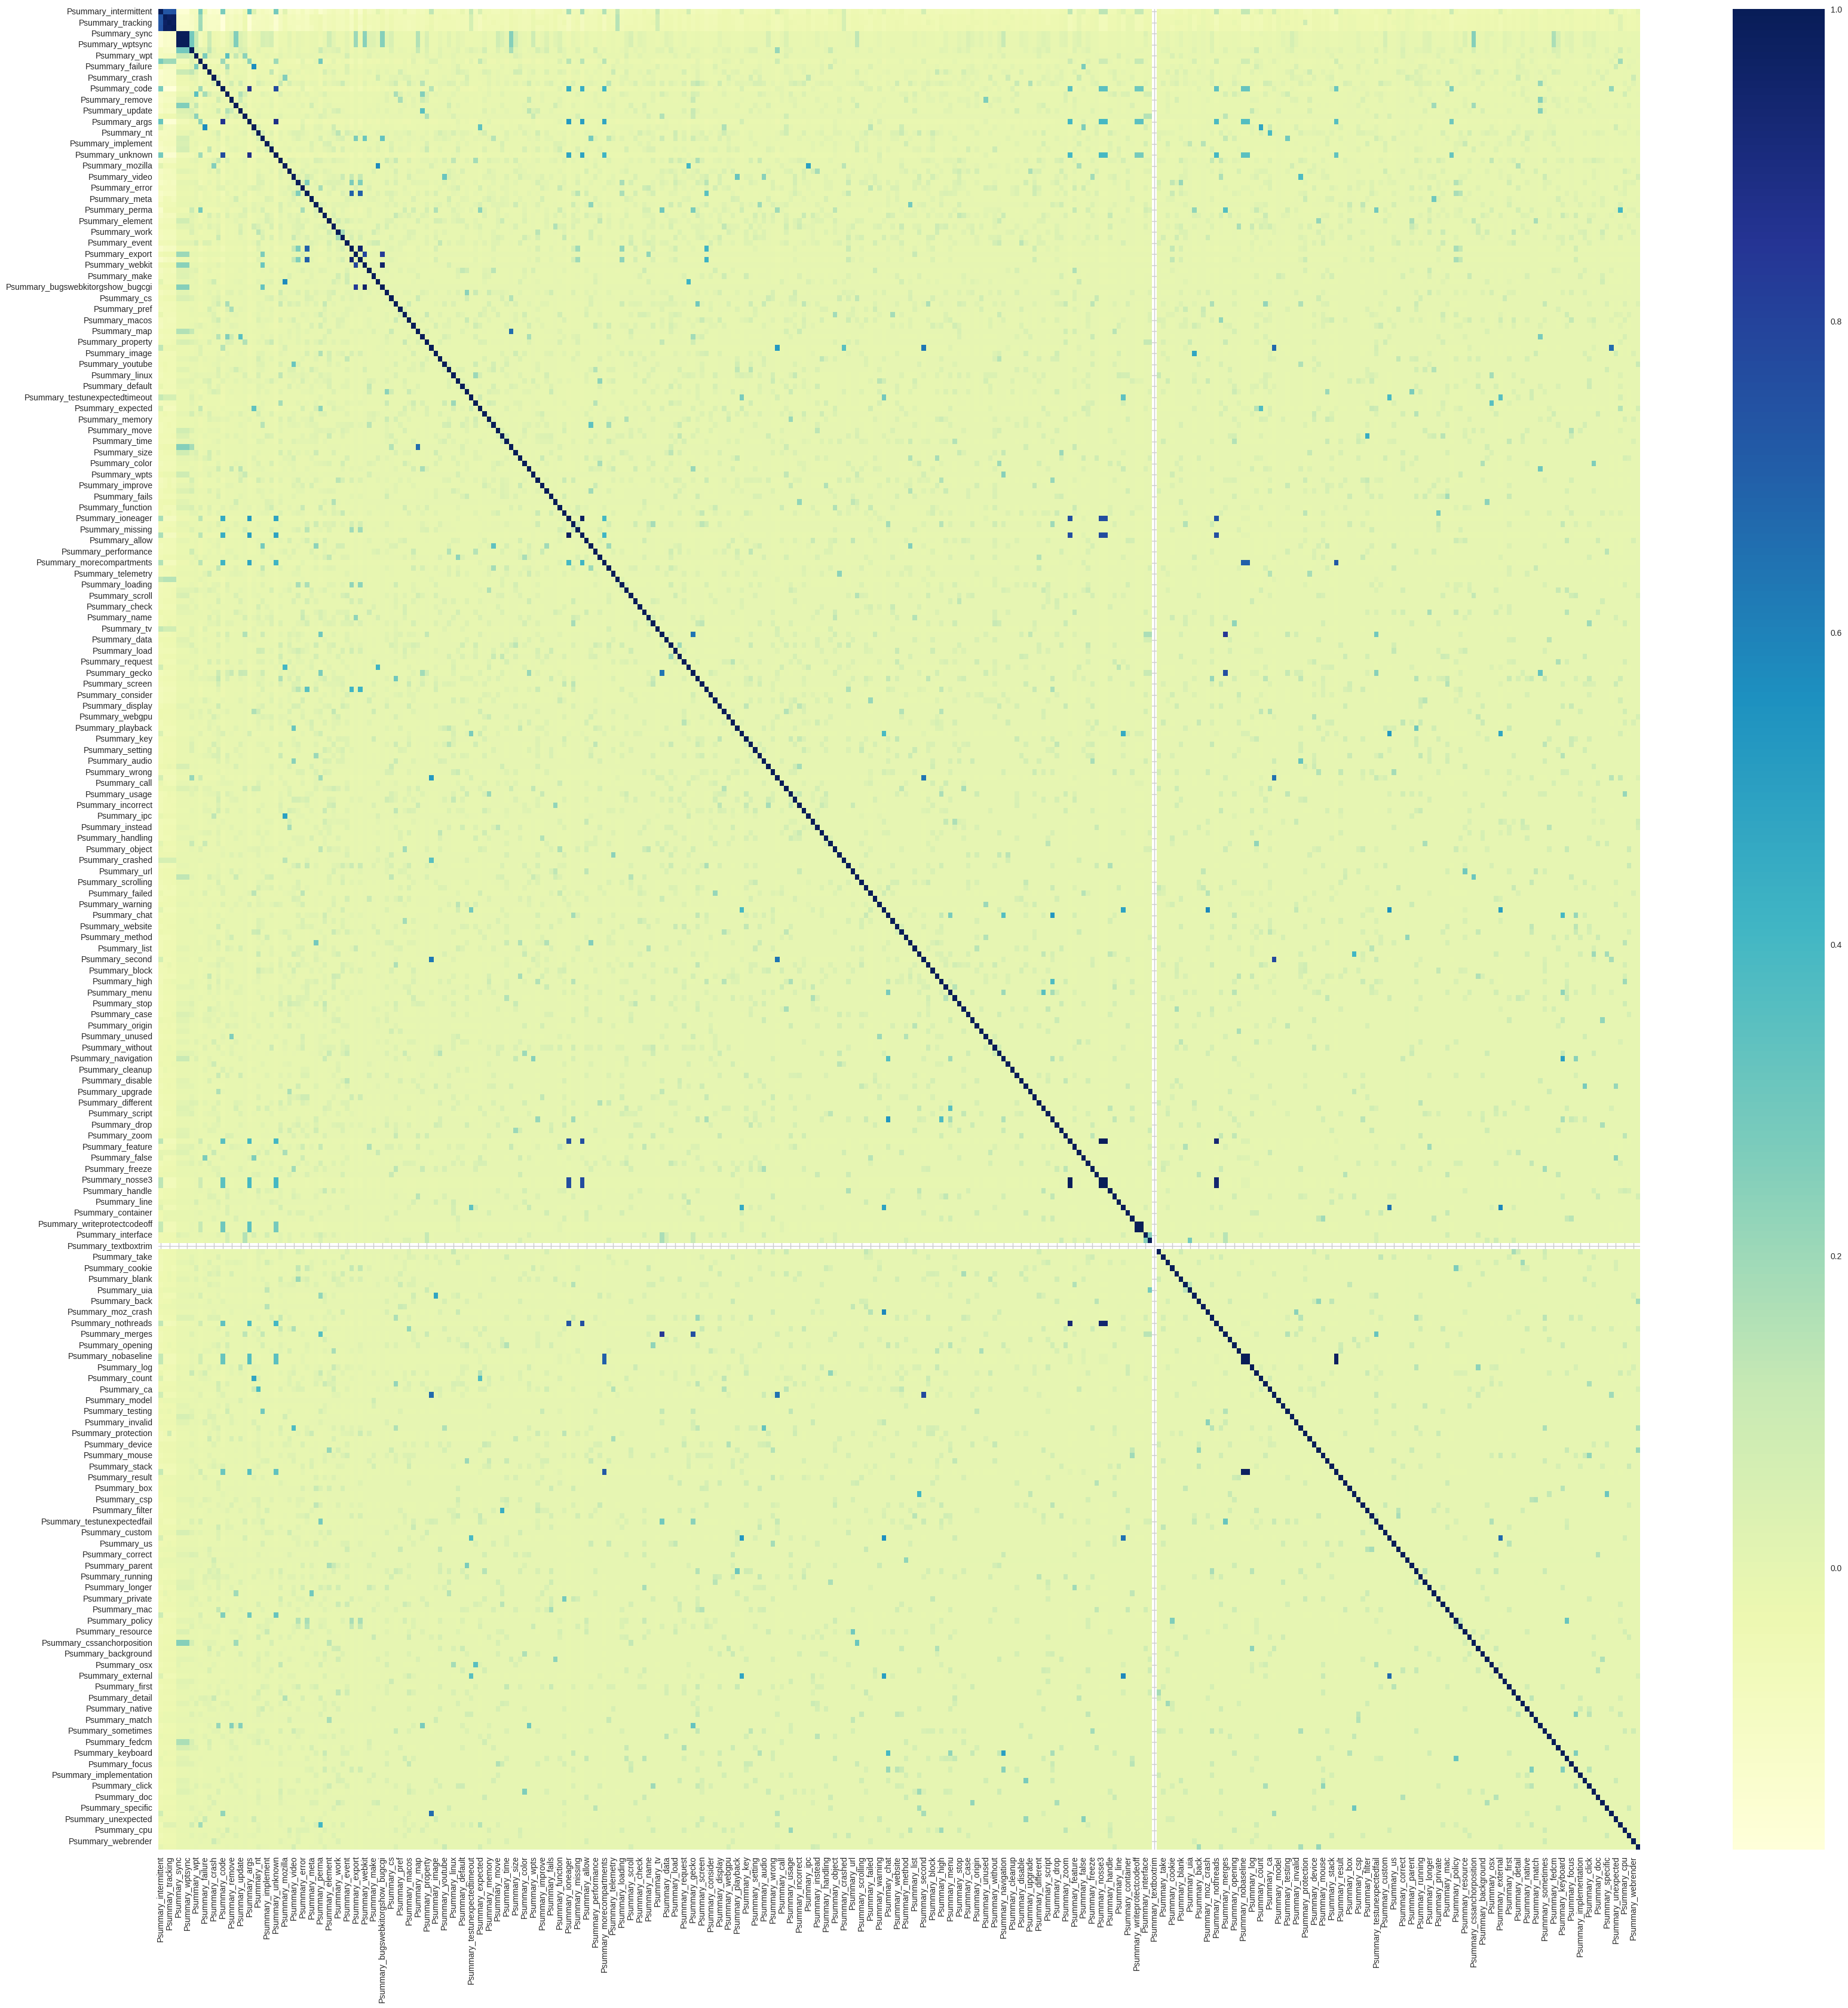

In [ ]:
# Import modules
import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sb

# Import file with data
dataHM = mergeddataP.copy()
# mergeddata[mergeddata.columns.drop(list(mergeddata.filter(regex='^Psummary')))]

# Print data that will be plotted
# Columns shown here are selected by corr() since
# they are ideal for the plot
# print(dataHM.corr(numeric_only=True))

# Plotting correlation heatmap
fig, ax = mp.subplots(figsize=(40, 40))
dataplot = sb.heatmap(dataHM.corr(numeric_only=True), cmap="YlGnBu", annot=False, ax=ax)

# Displaying heatmap
mp.show()


In [ ]:
threshold = 0.005
correlations = mergeddataS.corr()['severity'].abs().sort_values(ascending=False)
selected_features = correlations[correlations > threshold].index  # Set a threshold
print(correlations)
print(selected_features)
mergeddata = mergeddataS[selected_features]

severity                 1.000000
type_defect              0.457767
type_task                0.373556
version                  0.350471
type_enhancement         0.216913
resolution_INCOMPLETE    0.115843
resolution_WORKSFORME    0.076393
resolution_              0.067771
id                       0.062608
resolution_INVALID       0.055402
resolution_WONTFIX       0.040366
resolution_DUPLICATE     0.017682
assigned_to_detail.id    0.010912
resolution_FIXED         0.006552
Name: severity, dtype: float64
Index(['severity', 'type_defect', 'type_task', 'version', 'type_enhancement',
       'resolution_INCOMPLETE', 'resolution_WORKSFORME', 'resolution_', 'id',
       'resolution_INVALID', 'resolution_WONTFIX', 'resolution_DUPLICATE',
       'assigned_to_detail.id', 'resolution_FIXED'],
      dtype='object')


In [ ]:
threshold = 0.005
mergeddataP['severity'] = mergeddataS['severity']
correlations = mergeddataP.corr()['severity'].abs().sort_values(ascending=False)
selected_features = correlations[correlations > threshold].index  # Set a threshold
print(correlations)
print(selected_features)
mergeddata = pd.concat([mergeddata,mergeddataP[selected_features]])

severity                 1.000000
Psummary_intermittent    0.131275
Psummary_crash           0.126663
Psummary_strict          0.125892
Psummary_etp             0.117092
                           ...   
Psummary_time            0.000342
Psummary_gc              0.000163
Psummary_expose          0.000147
Psummary_custom          0.000104
Psummary_textboxtrim          NaN
Name: severity, Length: 335, dtype: float64
Index(['severity', 'Psummary_intermittent', 'Psummary_crash',
       'Psummary_strict', 'Psummary_etp', 'Psummary_probe', 'Psummary_page',
       'Psummary_set', 'Psummary_video', 'Psummary_displayed',
       ...
       'Psummary_wb', 'Psummary_policy', 'Psummary_thread',
       'Psummary_function', 'Psummary_call', 'Psummary_second',
       'Psummary_beta', 'Psummary_message', 'Psummary_instead',
       'Psummary_issue'],
      dtype='object', length=301)


In [ ]:
mergeddata.columns.tolist()

['severity',
 'type_defect',
 'type_task',
 'version',
 'type_enhancement',
 'resolution_INCOMPLETE',
 'resolution_WORKSFORME',
 'resolution_',
 'id',
 'resolution_INVALID',
 'resolution_WONTFIX',
 'resolution_DUPLICATE',
 'assigned_to_detail.id',
 'resolution_FIXED',
 'Psummary_intermittent',
 'Psummary_crash',
 'Psummary_strict',
 'Psummary_etp',
 'Psummary_probe',
 'Psummary_page',
 'Psummary_set',
 'Psummary_video',
 'Psummary_displayed',
 'Psummary_single',
 'Psummary_tracking',
 'Psummary_bug',
 'Psummary_add',
 'Psummary_enabled',
 'Psummary_keyboard',
 'Psummary_meta',
 'Psummary_button',
 'Psummary_nt',
 'Psummary_telemetry',
 'Psummary_remove',
 'Psummary_failure',
 'Psummary_sidebar',
 'Psummary_code',
 'Psummary_firefox',
 'Psummary_element',
 'Psummary_window',
 'Psummary_mac',
 'Psummary_loading',
 'Psummary_does_not',
 'Psummary_navigation',
 'Psummary_string',
 'Psummary_stop',
 'Psummary_macos',
 'Psummary_chat',
 'Psummary_scroll',
 'Psummary_audio',
 'Psummary_script

In [ ]:
from pycaret.classification import *

data = mergeddata

clf1 = setup(data.reset_index(drop=True), target='severity')

model = [create_model(i) for i in [
    'rf',
    'gbc',
    'et',
    'xgboost',
    'catboost',
    'lightgbm',
    'dt']]

for i in (range(7)):
    print(i)
    model[i].get_params()

,Description,Value
0,Session id,7695
1,Target,severity
2,Target type,Multiclass
3,Original data shape,"(8218, 69)"
4,Transformed data shape,"(8218, 69)"
5,Transformed train set shape,"(5752, 69)"
6,Transformed test set shape,"(2466, 69)"
7,Numeric features,58
8,Categorical features,10
9,Rows with missing values,100.0%


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6736,0.8473,0.6736,0.6864,0.6766,0.4765,0.4793
1,0.7240,0.8711,0.7240,0.7304,0.7222,0.5562,0.5610
2,0.6539,0.0000,0.6539,0.6750,0.6564,0.4467,0.4523
3,0.7061,0.0000,0.7061,0.7137,0.7048,0.5255,0.5302
4,0.6974,0.0000,0.6974,0.7076,0.6983,0.5134,0.5173
5,0.6904,0.0000,0.6904,0.7036,0.6902,0.5006,0.5067
6,0.7078,0.8618,0.7078,0.7196,0.7057,0.5265,0.5328
7,0.7043,0.8767,0.7043,0.7078,0.7032,0.5227,0.5252
8,0.6817,0.8465,0.6817,0.6973,0.6833,0.4920,0.4970


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7118,0.0000,0.7118,0.7153,0.7094,0.5344,0.5383
1,0.7587,0.0000,0.7587,0.7567,0.7544,0.6107,0.6143
2,0.6991,0.0000,0.6991,0.7101,0.6999,0.5207,0.5258
3,0.7217,0.0000,0.7217,0.7221,0.7194,0.5494,0.5517
4,0.7026,0.0000,0.7026,0.7191,0.7047,0.5280,0.5346
5,0.7130,0.0000,0.7130,0.7265,0.7140,0.5428,0.5490
6,0.7096,0.0000,0.7096,0.7241,0.7086,0.5316,0.5392
7,0.7391,0.0000,0.7391,0.7574,0.7365,0.5766,0.5795
8,0.7130,0.0000,0.7130,0.7236,0.7133,0.5433,0.5486


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6684,0.8277,0.6684,0.6875,0.6733,0.4706,0.4743
1,0.7257,0.8492,0.7257,0.7306,0.7231,0.5580,0.5628
2,0.6574,0.0000,0.6574,0.6756,0.6595,0.4529,0.4582
3,0.6904,0.0000,0.6904,0.7028,0.6911,0.5017,0.5067
4,0.6748,0.0000,0.6748,0.6977,0.6813,0.4816,0.4857
5,0.6904,0.0000,0.6904,0.7068,0.6922,0.5022,0.5078
6,0.6957,0.8578,0.6957,0.7173,0.6974,0.5103,0.5176
7,0.7009,0.8664,0.7009,0.7109,0.7019,0.5183,0.5216
8,0.6887,0.8356,0.6887,0.7074,0.6915,0.5047,0.5106


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7118,0.8684,0.7118,0.7102,0.7079,0.5320,0.5348
1,0.7500,0.8991,0.7500,0.7425,0.7438,0.5941,0.5967
2,0.6957,0.0000,0.6957,0.7068,0.6959,0.5120,0.5153
3,0.7235,0.0000,0.7235,0.7218,0.7192,0.5492,0.5521
4,0.6974,0.0000,0.6974,0.7157,0.6983,0.5166,0.5249
5,0.7183,0.0000,0.7183,0.7295,0.7182,0.5483,0.5542
6,0.7096,0.8728,0.7096,0.7236,0.7088,0.5293,0.5354
7,0.7391,0.8959,0.7391,0.7376,0.7348,0.5770,0.5806
8,0.7200,0.8777,0.7200,0.7302,0.7197,0.5509,0.5545


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7188,0.8723,0.7188,0.7099,0.7127,0.5425,0.5442
1,0.7552,0.9012,0.7552,0.7429,0.7471,0.6008,0.6028
2,0.6957,0.0000,0.6957,0.6973,0.6935,0.5115,0.5148
3,0.7322,0.0000,0.7322,0.7275,0.7273,0.5640,0.5665
4,0.6991,0.0000,0.6991,0.7072,0.6986,0.5176,0.5224
5,0.7096,0.0000,0.7096,0.7182,0.7088,0.5336,0.5389
6,0.7078,0.8795,0.7078,0.7166,0.7052,0.5244,0.5299
7,0.7322,0.8939,0.7322,0.7256,0.7266,0.5640,0.5663
8,0.7113,0.8809,0.7113,0.7119,0.7087,0.5361,0.5392


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7049,0.8645,0.7049,0.7067,0.7034,0.5234,0.5255
1,0.7483,0.8938,0.7483,0.7421,0.7433,0.5914,0.5932
2,0.6991,0.0000,0.6991,0.7232,0.7004,0.5170,0.5200
3,0.7357,0.0000,0.7357,0.7351,0.7311,0.5700,0.5738
4,0.7113,0.0000,0.7113,0.7239,0.7117,0.5362,0.5418
5,0.7148,0.0000,0.7148,0.7282,0.7155,0.5437,0.5498
6,0.7078,0.8706,0.7078,0.7190,0.7056,0.5250,0.5307
7,0.7443,0.8895,0.7443,0.7475,0.7417,0.5878,0.5921
8,0.7096,0.8769,0.7096,0.7242,0.7098,0.5348,0.5402


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6667,0.7832,0.6667,0.6846,0.6717,0.4667,0.4696
1,0.7205,0.7997,0.7205,0.7357,0.7217,0.5506,0.5557
2,0.6557,0.0000,0.6557,0.6741,0.6593,0.4518,0.4566
3,0.6887,0.0000,0.6887,0.7022,0.6902,0.4976,0.5019
4,0.6800,0.0000,0.6800,0.7063,0.6859,0.4905,0.4965
5,0.6957,0.0000,0.6957,0.7166,0.6999,0.5114,0.5163
6,0.6870,0.8107,0.6870,0.7062,0.6885,0.4934,0.4988
7,0.6904,0.8078,0.6904,0.7049,0.6935,0.5033,0.5068
8,0.6887,0.8023,0.6887,0.7044,0.6907,0.5020,0.5071


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

0
1
2
3
4
5
6


# Metrics

In [53]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

# Assuming you have y_test and y_pred (true and predicted labels)

def calculate_metrics(y_test, y_pred, class_names=None):
    """Calculates and prints various classification metrics."""

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Confusion Matrix with Class Names
    cm = confusion_matrix(y_test, y_pred)

    if class_names is not None:
        cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
        print(f"Confusion Matrix:\n{cm_df}")
    else:
        print(f"Confusion Matrix:\n{cm}")

    #Calculate Specificity, Recall, Precision, F1-Score for Multi-class
    num_classes = cm.shape[0]
    specificity = []
    recall = []
    precision = []
    f1 = []

    for i in range(num_classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)

        # accuracy.append(tp+tn/(tp+tn+fp+fn) if (tn + fp) != 0 else 0)
        specificity.append(tn / (tn + fp) if (tn + fp) != 0 else 0)
        recall.append(tp / (tp + fn) if (tp + fn) != 0 else 0)
        precision.append(tp / (tp + fp) if (tp + fp) != 0 else 0)
        f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) != 0 else 0)

    # print(f"Accuracy (per class): {accuracy}")
    print(f"Specificity (per class): {specificity}")
    print(f"Recall (per class): {recall}")
    print(f"Precision (per class): {precision}")
    print(f"F1-score (per class): {f1}")

  # AUC-ROC (Class-wise - for multi-class using One-vs-Rest)
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test_binarized = lb.transform(y_test)
    y_pred_binarized = lb.transform(y_pred) #Corrected: using y_pred for binarization
    for i in range(y_test_binarized.shape[1]):
        auc_roc_class = roc_auc_score(y_test_binarized[:, i], y_pred_binarized[:, i])
        print(f"AUC-ROC for class {class_names[i]}: {auc_roc_class:.4f}")


class_names = ['S1', 'S2', 'S3', 'S4']  # Replace with your actual class names
calculate_metrics(y_test, y_pred, class_names=class_names)

Accuracy: 0.8919
Confusion Matrix:
    S1   S2   S3   S4
S1  53    4    2    1
S2   0  243   44    0
S3   0   28  581   25
S4   0    9   76  683
Specificity (per class): [1.0, 0.9719562243502052, 0.8905829596412556, 0.9734964322120285]
Recall (per class): [0.8833333333333333, 0.8466898954703833, 0.916403785488959, 0.8893229166666666]
Precision (per class): [1.0, 0.8556338028169014, 0.8264580369843528, 0.9633286318758815]
F1-score (per class): [0.9380530973451328, 0.851138353765324, 0.8691099476439791, 0.9248476641841571]
AUC-ROC for class S1: 0.9417
AUC-ROC for class S2: 0.9093
AUC-ROC for class S3: 0.9035
AUC-ROC for class S4: 0.9314


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 8.5 MB/s eta 0:00:00


KeyboardInterrupt: 